# Model 5-2
Hyperparameter tuning for XGBoost Exploring hyper paramaters further. 
<li> Changing scoring to rmse</li>
<li> Without Standard Scaler</li>
<li> Removing values with low frequency

## Restult
Best Model:
<code>

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
</code >

## Future:
using the same parameters while the numerical data is standrdaized

In [1]:
# reading data from google drive 
# data paths whether notebook is run locally or google colab
import os
try:
    from google.colab import drive
    drive.mount('/content/drive')
    COMPETETION_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1"
    TRAIN_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/train.csv"
    TEST_DATA_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/data/test.csv"
    OUTPUT_PATH = "/content/drive/MyDrive/30-days-of-ml-competition1/output"
except:
    TRAIN_DATA_PATH = os.path.join("data", "train.csv")
    TEST_DATA_PATH = os.path.join("data", "test.csv")

print(f"Training Path {TRAIN_DATA_PATH}")
print(f"Testing Path {TEST_DATA_PATH}")



Training Path data/train.csv
Testing Path data/test.csv


In [42]:

# library imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# modeling
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
def read_organise_data(train=TRAIN_DATA_PATH):
    """read the data from a path and splitting to features and target

    Args:
        train (path, optional): The path of training data file to. Defaults to TRAIN_DATA_PATH.

    Returns:
        X, y: X for features and y for target
    """
    full_df = pd.read_csv(train, index_col="id")
    print(f"Shape of Dataset: {full_df.shape}")
    return full_df

df= read_organise_data()
X_test = pd.read_csv(TEST_DATA_PATH, index_col='id')
print(f"Shape of Test set {X_test.shape}")

Shape of Dataset: (300000, 25)
Shape of Test set (200000, 24)


In [18]:
df = df[(df.target >=6.9) & (df.target <=10.4)]

## Understanding Data

In [20]:
df.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000,298733.000000
mean,0.527292,0.460916,0.490553,0.496645,0.491624,0.510447,0.467461,0.537085,0.498391,0.474778,0.474391,0.473164,0.494528,0.508267,8.244174
std,0.230592,0.213986,0.253324,0.219218,0.240082,0.228247,0.210319,0.218137,0.239944,0.218001,0.255933,0.222018,0.247283,0.222965,0.728895
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,6.903415
25%,0.405954,0.310495,0.300645,0.329638,0.284184,0.354081,0.342862,0.355795,0.332398,0.306736,0.275909,0.308128,0.289074,0.300663,7.746106
50%,0.496993,0.427897,0.502511,0.464997,0.389902,0.488621,0.429360,0.504616,0.439015,0.434521,0.459798,0.433767,0.422836,0.472390,8.191958
75%,0.667947,0.615112,0.647567,0.664358,0.696626,0.669576,0.573358,0.703385,0.606037,0.614035,0.691529,0.642004,0.714415,0.758453,8.726105
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.399988


In [21]:
# checking for null values in the full dataset
df.isnull().any().sum() # no null value in dataset

0

In [22]:
y = df.target.copy()
X = df.drop('target', axis=1).copy()

In [29]:
# splitting the data
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.1,
                                                      random_state= 42)

In [30]:
# categorical columns start with cat
categorical_cols = [cname for cname in X.columns if 'cat' in cname]
# numerical columns starts with cont
numerical_cols = [cname for cname in X.columns if 'cont' in cname]

In [31]:

# checking the cardinality of the categorical columns
for cname in categorical_cols:
    num_unique = X[cname].nunique()
    print(f"{cname} has {num_unique}")
    if num_unique > 10:
        print(f"\t{cname} has a high cardinality")

# eventhough cat9 col has more than 10 unique values, we will still use the OnehotEncoder 

cat0 has 2
cat1 has 2
cat2 has 2
cat3 has 4
cat4 has 4
cat5 has 4
cat6 has 8
cat7 has 8
cat8 has 7
cat9 has 15
	cat9 has a high cardinality


In [32]:

# not including numerical transformer
# numerical and categorical transformations
num_transformer = StandardScaler()
cat_transformer = OrdinalEncoder()
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, categorical_cols),
], remainder='passthrough')

In [37]:
def get_score(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    my_pipeline = Pipeline(steps=[
                                  ('preprocessor', preprocessor),
                                  ('model', model)
    ])
    my_pipeline.fit(X_t, y_t)
    preds = my_pipeline.predict(X_v)
    return mean_squared_error(y_v, preds)
    

In [43]:
rmse_scores = {}
n_estimators = [1350, 1400, 1500, 1600]
for estimators in n_estimators:
    xgb_model = XGBRegressor(n_estimators = estimators, objective='reg:squarederror', random_state=42)
    rmse_scores[estimators]= get_score(xgb_model)**0.5
    print(f"Number of Estimators: {estimators}\nScore: {rmse_scores[estimators]}")


Number of Estimators: 1350
Score: 0.7244632097535231
Number of Estimators: 1400
Score: 0.7252217350670602
Number of Estimators: 1500
Score: 0.726664750688216
Number of Estimators: 1600
Score: 0.7275422241876456


In [44]:
n_estimators = [600, 700, 800, 900, 1000, 1100, 1200]
for estimators in n_estimators:
    xgb_model = XGBRegressor(n_estimators = estimators, objective='reg:squarederror', random_state=42)
    rmse_scores[estimators]= get_score(xgb_model)**0.5
    print(f"Number of Estimators: {estimators}\nScore: {rmse_scores[estimators]}")

Number of Estimators: 600
Score: 0.7135544544893807
Number of Estimators: 700
Score: 0.7155574776597493
Number of Estimators: 800
Score: 0.7173322694744654
Number of Estimators: 900
Score: 0.7193351848998087
Number of Estimators: 1000
Score: 0.7204369475555011
Number of Estimators: 1100
Score: 0.7218677323501987
Number of Estimators: 1200
Score: 0.723020943316984


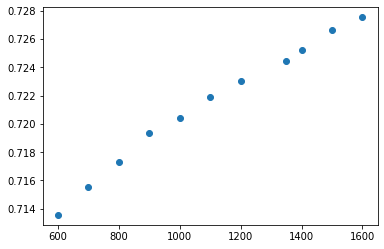

In [46]:
plt.scatter(rmse_scores.keys(), rmse_scores.values())

In [48]:
best_n_estimator = min(rmse_scores, key=rmse_scores.get)
best_model = XGBRegressor(n_estimators = best_n_estimator, objective='reg:squarederror', random_state=42)
print(f"Best Estimator: {best_n_estimator}")
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

Best Estimator: 600


In [49]:
best_pipeline.fit(X, y)

KeyboardInterrupt: 

In [39]:
predictions = best_pipeline.predict(X_test)

In [40]:
OUTPUT_PATH = 'output'
def output_submission(prediction, file_name):
    """creating a kaggle submission file

    Args:
        prediction (array): an array of predictions of the test dataset
        file_name (string): a string for the name without the extension
    """
    my_submission = pd.DataFrame({'target': predictions},
                                 index=X_test.index)
    #my_submission.set_index('id')
    file_path = os.path.join(OUTPUT_PATH,file_name)
    my_submission.to_csv(f'{file_path}.csv')
    print(f'A submission file has been made at {file_path}')

In [41]:
output_submission(predictions, "Submission5-2")

A submission file has been made at output/Submission10


In [42]:
df

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499993,B,B,A,A,B,D,A,E,A,I,...,0.769792,0.450538,0.934360,1.005077,0.853726,0.422541,1.063463,0.697685,0.506404,7.945605
499996,A,B,A,C,B,B,A,E,E,F,...,0.528056,0.508502,0.358247,0.257825,0.433525,0.301015,0.268447,0.577055,0.823611,7.326118
499997,B,B,A,C,B,C,A,E,G,F,...,0.688747,0.372425,0.364936,0.383224,0.551825,0.661007,0.629606,0.714139,0.245732,8.706755
